Nous allons simuler un ring avec en entrée une courbe représentant des stimuli "naturels"

* simulations center-surround
* synthèse 
* écriture poster en latex

<!-- TEASER_END -->


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import brian2 as sim

fig_width_pt = 646.79  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches

WARNING    /usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in double_scalars
 [py.warnings]


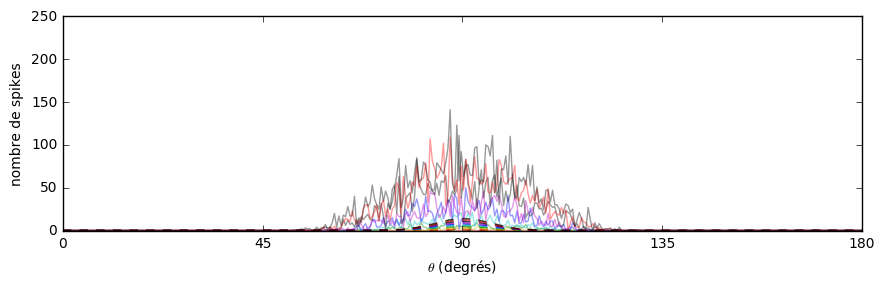

In [2]:
N_theta = 360
def ring(N_theta=N_theta, # nombre de neurones d'entrée = nombre neurones du ring
         tau=10*sim.ms, 
         tau_e=2*sim.ms,
         sigma_theta_ff=.5, # bandwidth de connections feed-forward
         sigma_theta_lat=.8, # bandwidth de connections latérales
         weight_ff=1., # poids des connections feed-forward
         weight_lat=.3, # poids des connections latérales
         input_rate=150, # échelle pour convertir l'entrée en un nombre de spikes / s
         m_input=np.pi/2, # orientation moyenne de l'entrée (radians)
         B_theta=.2,  # bandwidth de l'entrée (radians)
         m_gabor=np.linspace(0, np.pi, N_theta, endpoint=False), # orientations correspondant aux neurones
         sigma_gabor=.1, # bandwidth du gabor (radians)
         dx=np.pi/N_theta, # largeur des bins couverts par chaque neurone
         sparseness=.5,
         t_run=2):
    
    # BRIAN
    input_rates = sim.zeros(N_theta)
    # formule analytique donnant une approximation de l'entrée en convoluant un motion cloud avec un gabor
    input_rates = np.exp(-2*((m_gabor-m_input)**2)/(B_theta**2+sigma_gabor**2))
    input_rates *= dx/(2*np.pi*B_theta*sigma_gabor)
    input_rates *= input_rate
    #print(input_rates)
    
    eqs='''
    dv/dt=(I-v)/tau : volt
    dI/dt=-I/tau_e : volt
    '''
    layer0 = sim.PoissonGroup(N_theta, rates=input_rates*sim.Hz)
    layerE = sim.NeuronGroup(N_theta, model=eqs, threshold='v>1*mV', reset='v=0*mV', method='linear')

    feedforward = sim.Synapses(layer0, layerE, 'w: volt', on_pre='v+=w')
    feedforward.connect(p=sparseness)
    feedforward.w = 'exp((cos(2*pi*(i-j)/N_theta)-1.)/sigma_theta_ff**2)/sigma_theta_ff*weight_ff*mV' 

    lateralmap = lambda i, j:np.exp((np.cos(2*np.pi*(i-j)/N_theta)-1.)/sigma_theta_lat**2)/sigma_theta_lat*weight_lat*sim.mV
    WEE = sim.Synapses(layerE, layerE, 'w: volt', on_pre='v+=w')
    WEE.connect(p=sparseness)
    feedforward.w = 'exp((cos(2*pi*(i-j)/N_theta)-1.)/sigma_theta_lat**2)/sigma_theta_lat*weight_lat*mV' 

    spikes = sim.SpikeMonitor(layerE)
    sim.run(t_run * sim.second)
    #print(spikes.count)
    return input_rates, np.array(spikes.count)

N_test = 10
input_rate = np.linspace(0.06, 200., N_test)
theta = np.linspace(0, np.pi, N_theta)
m_input = np.pi/2
sigma_gabor = .1

mean = np.zeros((N_test))
gain_in = np.zeros((N_test))
gain_out = np.zeros((N_test))
bandwidth = np.zeros((N_test))

fig, ax = plt.subplots(figsize=(fig_width, fig_width*6/18.))
for i_test, (input_rate_, color) in enumerate(zip(input_rate, ['k', 'r', 'y', 'g', 'c', 'b', 'm', 'k', 'r', 'k', 'g'])):
    input_rates, spikes_N = ring(input_rate=input_rate_*sim.Hz)
    gain_in[i_test] = np.sum(input_rates)*1./N_theta
    gain_out[i_test] = np.sum(spikes_N)*1./N_theta
    mean[i_test] = np.sum(spikes_N*theta)/np.sum(spikes_N)
    bandwidth[i_test] = np.sqrt(np.sum(spikes_N*(theta-mean[i_test])**2)/np.sum(spikes_N)) 
    ax.plot(theta*180/np.pi, input_rates, color, linestyle='--', alpha=0.7)
    ax.plot(theta*180/np.pi, spikes_N, color, alpha=0.4)
ax.set_xlim([0, 180])
ax.set_xticks(np.linspace(0, 180, 5))
ax.set_yticks(np.linspace(0, 250, 6))
ax.set_xlabel(r'$\theta$ ' u'(degrés)')
ax.set_ylabel('nombre de spikes')
#ax.set_title(u'Courbe de sélectivité')
plt.tight_layout()
#fig.savefig('figures/selectivite_inputrate(week6).pdf')

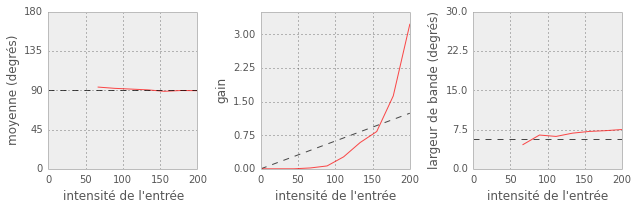

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(fig_width, fig_width*6/18.))
ax[0].plot(input_rate, mean*180/np.pi, 'r', alpha=0.7)
ax[0].plot(input_rate, m_input*np.ones(N_test)*180/np.pi, 'k--', alpha=0.7)
ax[0].set_ylim([0., 180])
ax[0].set_yticks(np.linspace(0, 180, 5))
ax[0].set_xticks(np.linspace(0, 200, 5))
ax[1].plot(input_rate, gain_in, 'k--', alpha=0.7)
ax[1].plot(input_rate, gain_out, 'r', alpha=0.7)
ax[1].set_xticks(np.linspace(0, 200, 5))
ax[1].set_yticks(np.linspace(0, 3, 5))
ax[2].plot(input_rate, bandwidth*180/np.pi, 'r', alpha=0.7)
ax[2].plot(input_rate, sigma_gabor*np.ones(N_test)*180/np.pi, 'k--', alpha=0.7)
ax[2].set_xticks(np.linspace(0, 200, 5))
ax[2].set_yticks(np.linspace(0, 30, 5))
#ax[2].set_ylim([0, 15.])

ax[0].set_xlabel(u"intensité de l'entrée")
ax[0].set_ylabel(u'moyenne (degrés)')

ax[1].set_xlabel(u"intensité de l'entrée")
ax[1].set_ylabel(r'gain')

ax[2].set_xlabel(u"intensité de l'entrée")
_ = ax[2].set_ylabel(u'largeur de bande (degrés)')
plt.tight_layout()
fig.savefig('figures/mean_gain_bandwith_inputrate(week6).pdf')

quand sigma_input augmente, la courbe de selectivité diminue et sa largueur semble diminuée !

In [14]:
print gain_out

[ 0.          0.          0.          0.01944444  0.06388889  0.26666667
  0.58611111  0.83055556  1.625       3.22222222]


In [15]:
mean

array([        nan,         nan,         nan,  1.63517835,  1.61017562,
        1.59504376,  1.57956802,  1.55055792,  1.5667649 ,  1.56344854])

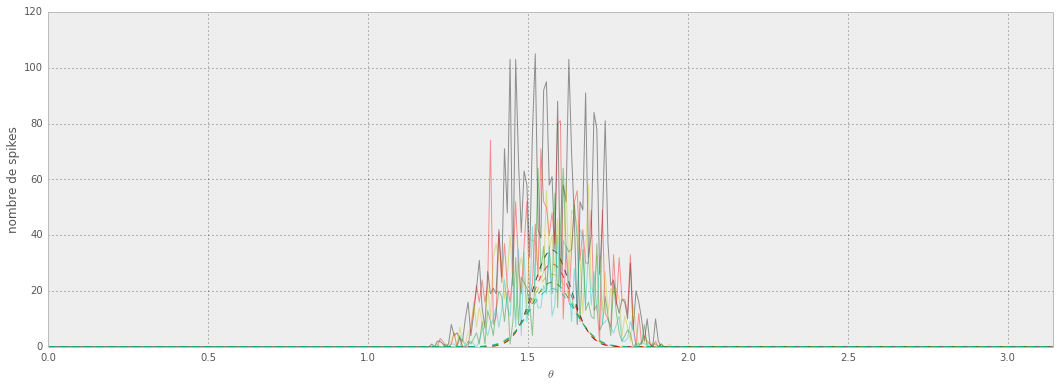

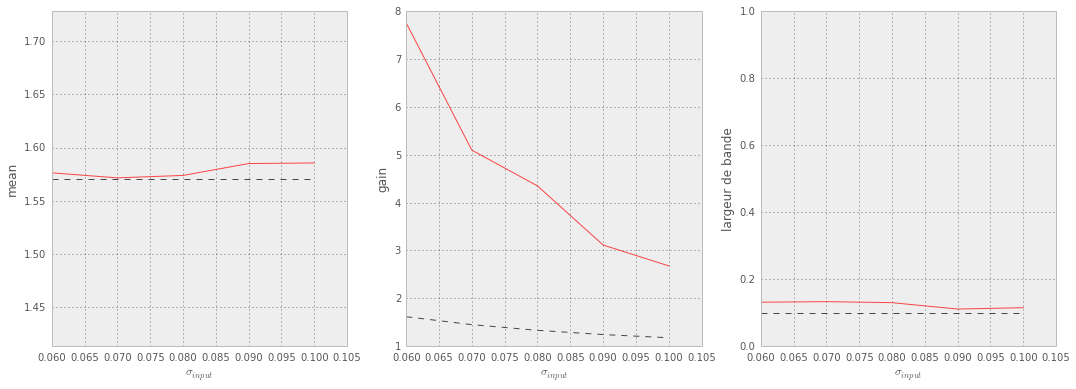

In [16]:
N_test = 5
B_theta = np.linspace(0.06, .1, N_test)
theta = np.linspace(0, np.pi, N_theta)
m_input = np.pi/2
sigma_gabor = .1

mean = np.zeros((N_test))
gain_in = np.zeros((N_test))
gain_out = np.zeros((N_test))
bandwidth = np.zeros((N_test))

fig, ax = plt.subplots(figsize=(18, 6))
for i_test, (B_theta_, color) in enumerate(zip(B_theta, ['k', 'r', 'y', 'g', 'c', 'b', 'm', 'k', 'r', 'y',  'g'])):
    rates, spikes_N = ring(B_theta=B_theta_)
    gain_in[i_test] = np.sum(rates)*1./N_theta
    gain_out[i_test] = np.sum(spikes_N)*1./N_theta
    mean[i_test] = np.sum(spikes_N*theta)/np.sum(spikes_N)
    bandwidth[i_test] = np.sqrt(np.sum(spikes_N*(theta-mean[i_test])**2)/np.sum(spikes_N)) 
    ax.plot(theta, rates, color, linestyle='--', alpha=0.7)
    ax.plot(theta, spikes_N, color, alpha=0.4)
ax.set_xlim([0, np.pi])
ax.set_xlabel(r'$\theta$')
ax.set_ylabel('nombre de spikes')
#ax.set_title('courbe de selectivite')

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].plot(B_theta, mean, 'r', alpha=0.7)
ax[0].plot(B_theta, m_input*np.ones(N_test), 'k--', alpha=0.7)
ax[0].set_ylim([.9*m_input, 1.1*m_input])
ax[1].plot(B_theta, gain_in, 'k--', alpha=0.7)
ax[1].plot(B_theta, gain_out, 'r', alpha=0.7)
ax[2].plot(B_theta, bandwidth, 'r', alpha=0.7)
ax[2].plot(B_theta, sigma_gabor*np.ones(N_test), 'k--', alpha=0.7)
ax[2].set_ylim([0, 1.])

ax[0].set_xlabel(r'$\sigma_{input}$')
ax[0].set_ylabel(r'mean')

ax[1].set_xlabel(r'$\sigma_{input}$')
_ = ax[1].set_ylabel(r'gain')

ax[2].set_xlabel(r'$\sigma_{input}$')
_ = ax[2].set_ylabel(r'largeur de bande')

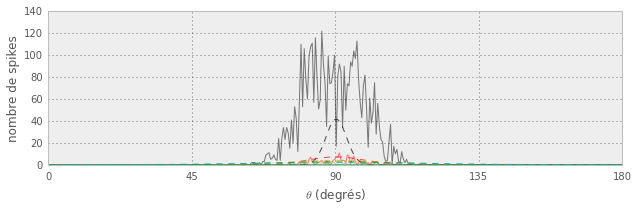

In [17]:
N_test = 5
m_input = np.pi/2
sigma_gabor = .1

B_theta = np.linspace(0.05, 1., N_test)
sigma_input = np.sqrt(.25/2*(B_theta**2+sigma_gabor**2))
theta = np.linspace(0, np.pi, N_theta)

mean = np.zeros((N_test))
gain_in = np.zeros((N_test))
gain_out = np.zeros((N_test))
bandwidth = np.zeros((N_test))

fig, ax = plt.subplots(figsize=(fig_width, fig_width*6/18.))
for i_test, (B_theta_, color) in enumerate(zip(B_theta, ['k', 'r', 'y', 'g', 'c', 'b', 'm', 'k', 'r', 'y',  'g'])):
    rates, spikes_N = ring(B_theta=B_theta_)
    gain_in[i_test] = np.sum(rates)*1./N_theta
    gain_out[i_test] = np.sum(spikes_N)*1./N_theta
    mean[i_test] = np.sum(spikes_N*theta)/np.sum(spikes_N)
    bandwidth[i_test] = np.sqrt(np.sum(spikes_N*(theta-mean[i_test])**2)/np.sum(spikes_N)) 
    ax.plot(theta*180/np.pi, rates, color, linestyle='--', alpha=0.7)
    ax.plot(theta*180/np.pi, spikes_N, color, alpha=0.5)
ax.set_xlim([0, 180])
ax.set_xticks(np.linspace(0, 180, 5))
#ax.set_yticks(np.linspace(0, 60, 5))
ax.set_xlabel(r'$\theta$ ' u'(degrés)')
ax.set_ylabel(r'nombre de spikes')
#ax.set_title(u'Courbe de sélectivité')
plt.tight_layout()
fig.savefig('figures/selectivite_sigmainput(week6).pdf')

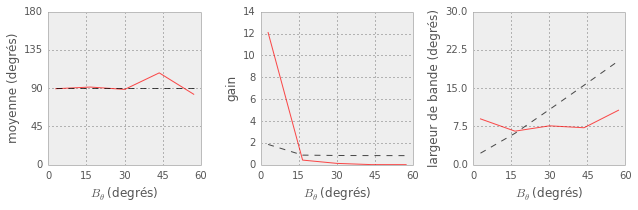

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(fig_width, fig_width*6/18.))
ax[0].plot(B_theta*180/np.pi, mean*180/np.pi, 'r', alpha=0.7)
ax[0].plot(B_theta*180/np.pi, m_input*np.ones(N_test)*180/np.pi, 'k--', alpha=0.7)
ax[0].set_ylim([0, 180])
ax[0].set_xticks(np.linspace(0, 60, 5))
ax[0].set_yticks(np.linspace(0, 180, 5))
ax[1].plot(B_theta*180/np.pi, gain_in, 'k--', alpha=0.7)
ax[1].plot(B_theta*180/np.pi, gain_out, 'r', alpha=0.7)
ax[1].set_xticks(np.linspace(0, 60, 5))
#ax[1].set_yticks(np.linspace(0, 1, 5))
#ax[1].set_ylim([0, 1.])
ax[2].plot(B_theta*180/np.pi, bandwidth*180/np.pi, 'r', alpha=0.7)
ax[2].plot(B_theta*180/np.pi, sigma_input*180/np.pi, 'k--', alpha=0.7)
ax[2].set_xticks(np.linspace(0, 60, 5))
ax[2].set_yticks(np.linspace(0, 30, 5))
#ax[2].set_ylim([0, 60.])

ax[0].set_xlabel(r'$B_{\theta}$ ' u'(degrés)')
ax[0].set_ylabel(u'moyenne (degrés)')

ax[1].set_xlabel(r'$B_{\theta}$ ' u'(degrés)')
_ = ax[1].set_ylabel(r'gain')

ax[2].set_xlabel(r'$B_{\theta}$ ' u'(degrés)')
_ = ax[2].set_ylabel(u'largeur de bande (degrés)')
plt.tight_layout()
fig.savefig('figures/mean_gain_bandwith_sigmainput(week6).pdf')